In [241]:
# system
from os import listdir
from os.path import isfile, join

# arrays and visualisation
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

# image
from PIL import Image
import imageio

# tensors
import torch
from torchvision import transforms

In [242]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [243]:
# DATA_DIR = "/kaggle/input/hpa-single-cell-image-classification"
DATA_DIR = "alpha layer test/"

In [345]:
def list_data_files(dir_):
    return (dir_+f for f in listdir(dir_) if isfile(join(dir_, f)))

In [346]:
tuple(list_data_files(DATA_DIR))

('alpha layer test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_alpha00.png',
 'alpha layer test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_blue.png',
 'alpha layer test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_green.png',
 'alpha layer test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_red.png',
 'alpha layer test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_yellow.png')

In [347]:
def get_merged_files(dir_, n_max = None):
    if n_max is None:
        n_max = np.inf
    prev_prefix = None
    merged_list = []
    curr_list = []
    
    sub_lists = 0
    for f in list_data_files(dir_):
        prefix = f.rsplit("_",1)[0]
        if  prefix != prev_prefix:
            merged_list.append(curr_list)
            prev_prefix = prefix
            curr_list = []
            sub_lists += 1
        if sub_lists > n_max:
            break
        curr_list.append(f)

    merged_list.append(curr_list)
    # Gets rid of the first necessary empty list.
    # Better than adding a " and if prev_prefix is not None" to the if
    return merged_list[1:]

In [348]:
def norm_img(img: np.ndarray):
    if type(img) is str:
        return imageio.imread(img)/(2**16)
    return img/(2**16)

In [418]:
def compose_rgba(imgs, factor = 0.5):
    if factor>1 or factor <0:
        raise ValueError(f"Incorrect factor value {factor}. The factor value should be between 0 and 1.")
    # b g r y <=> b a r g  ->  r g b a
    ret = np.array(imgs)
    rgba = np.zeros_like(ret)
    rgba[3] = ret[1]  
    rgba[[0, 1, 2]] = ret[[2, 3, 0]]
    rgba[3] = (rgba[:3].sum(axis=0)/3) + (rgba.sum(axis=0) > (1 - factor))
    return np.clip(np.transpose(rgba, (1, 2, 0)), 0, 1)


In [419]:
def compose_image(paths: str, factor=0.5):
    return compose_rgba(tuple(map(norm_img, paths)), factor)

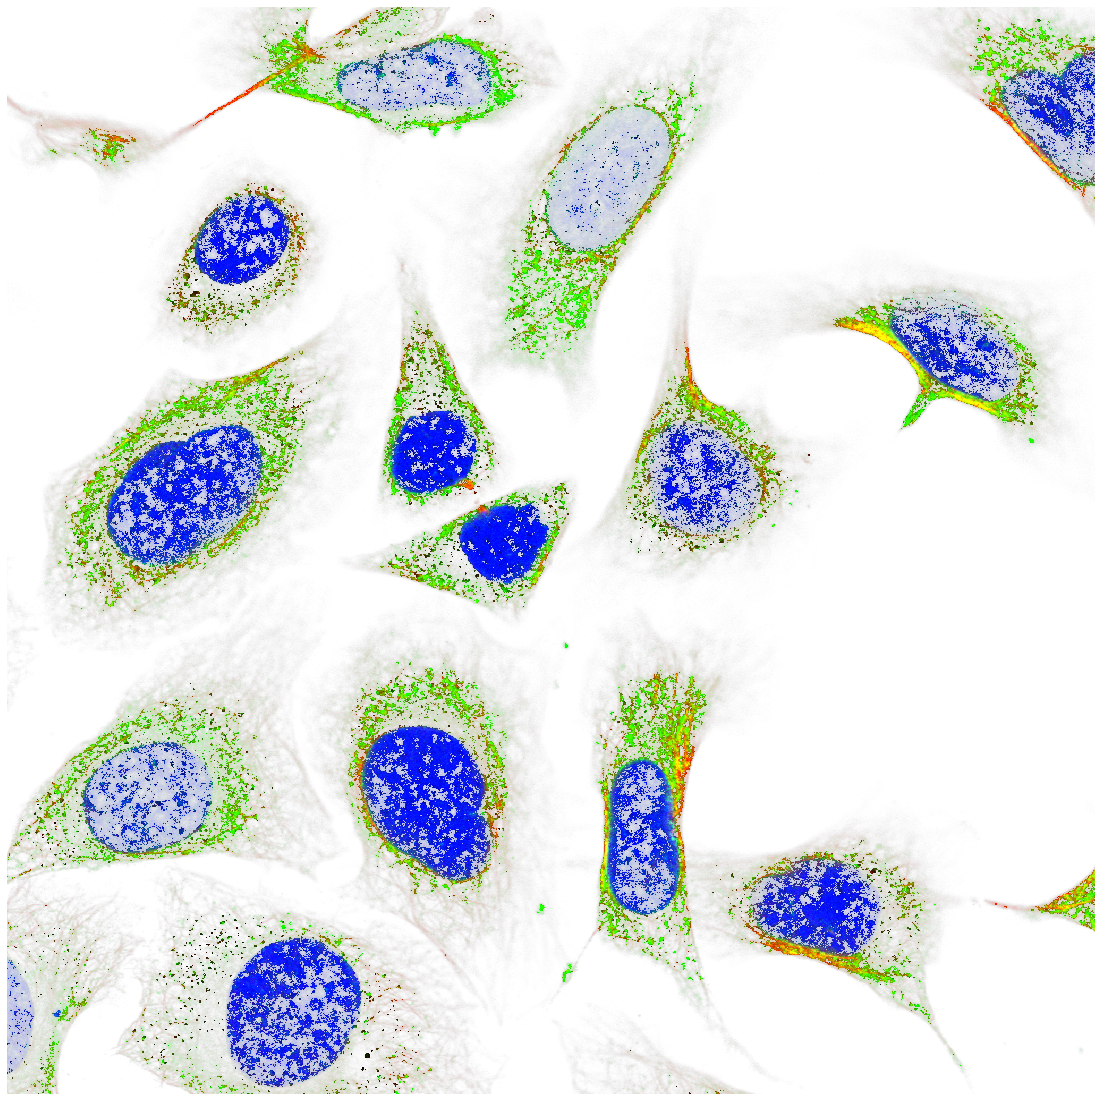

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [447]:
factor = 0
merged_imgs = get_merged_files(DATA_DIR, 1)
im = compose_image(merged_imgs[0], factor)
plt.imshow(im)
plt.axis('off')
plt.show()
dest_file = f"{merged_imgs[0][0].rsplit('/')[0]}/output/{merged_imgs[0][0].split('/', 1)[1].rsplit('_',1)[0]}_alpha_f_{str(factor).replace('.', '_')}.png"
imageio.imwrite(dest_file, im)

In [104]:
def image_to_tensor(file_list):
    ret = []
    for i, file in enumerate(file_list):
        image = Image.open(file)
        ret.append(transforms.ToTensor()(image).unsqueeze_(0))
    return torch.stack(ret)

In [105]:
image_to_tensor(get_merged_files(DATA_DIR)[0])

N:\Conda folders\envs\Env_gpu\lib\site-packages\torchvision\transforms\functional.py:70: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.int32, copy=False))


tensor([[[[[    0,     0,     0,  ...,     0,     0,     0],
           [    0,     0,     0,  ...,     0,     0,     0],
           [    0,     0,     0,  ...,     0,     0,     0],
           ...,
           [    0,     0,   354,  ...,     0,     0,     0],
           [  231,     0,   582,  ...,     0,     0,     0],
           [    0,     0,     0,  ...,     0,     0,     0]]]],



        [[[[    0,     0,     0,  ...,   816,   243,  3114],
           [    0,     0,     0,  ...,   331,  1664,     0],
           [    0,     0,     0,  ...,   834,  1399,     0],
           ...,
           [ 6482,  2118,  5793,  ...,     0,     0,     0],
           [  372,  2320,     0,  ...,     0,     0,     0],
           [ 1185,  1495,   510,  ...,     0,     0,     0]]]],



        [[[[    0,     0,     0,  ...,   826,   448,   131],
           [    0,     0,     0,  ...,   838,  1404,   956],
           [    0,     0,     0,  ...,  1160,  1619,  1274],
           ...,
           [ 9797, 12622,

# Reffered notebooks methods

In [2]:
def plot_rgb(arr, figsize=(12,12)):
    """ Plot 3 Channel Microscopy Image """
    plt.figure(figsize=figsize)
    plt.title(f"RGB Composite Image", fontweight="bold")
    plt.imshow(arr)
    plt.axis(False)
    plt.show()
    
    
def convert_rgby_to_rgb(arr):
    """ Convert a 4 channel (RGBY) image to a 3 channel RGB image.
    
    Advice From Competition Host/User: lnhtrang

    For annotation (by experts) and for the model, I guess we agree that individual 
    channels with full range px values are better. 
    In annotation, we toggled the channels. 
    For visualization purpose only, you can try blending the channels. 
    For example, 
        - red = red + yellow
        - green = green + yellow/2
        - blue=blue.
        
    Args:
        arr (numpy array): The RGBY, 4 channel numpy array for a given image
    
    Returns:
        RGB Image
    """
    
    rgb_arr = np.zeros_like(arr[..., :-1])
    rgb_arr[..., 0] = arr[..., 0]
    rgb_arr[..., 1] = arr[..., 1]+arr[..., 3]/2
    rgb_arr[..., 2] = arr[..., 2]
    
    return rgb_arr

In [5]:
def plot_ex(arr, figsize=(20,6), title=None, plot_merged=True, rgb_only=False):
    """ Plot 4 Channels Side by Side """
    if plot_merged and not rgb_only:
        n_images=5 
    elif plot_merged and rgb_only:
        n_images=4
    elif not plot_merged and rgb_only:
        n_images=4
    else:
        n_images=3
    plt.figure(figsize=figsize)
    if type(title) == str:
        plt.suptitle(title, fontsize=20, fontweight="bold")

    for i, c in enumerate(["Red Channel – Microtubles", "Green Channel – Protein of Interest", "Blue - Nucleus", "Yellow – Endoplasmic Reticulum"]):
        if not rgb_only:
            ch_arr = np.zeros_like(arr[..., :-1])        
        else:
            ch_arr = np.zeros_like(arr)
        if c in ["Red Channel – Microtubles", "Green Channel – Protein of Interest", "Blue - Nucleus"]:
            ch_arr[..., i] = arr[..., i]
        else:
            if rgb_only:
                continue
            ch_arr[..., 0] = arr[..., i]
            ch_arr[..., 1] = arr[..., i]
        plt.subplot(1,n_images,i+1)
        plt.title(f"{c.title()}", fontweight="bold")
        plt.imshow(ch_arr)
        plt.axis(False)
        
    if plot_merged:
        plt.subplot(1,n_images,n_images)
        
        if rgb_only:
            plt.title(f"Merged RGB", fontweight="bold")
            plt.imshow(arr)
        else:
            plt.title(f"Merged RGBY into RGB", fontweight="bold")
            plt.imshow(convert_rgby_to_rgb(arr))
        plt.axis(False)
        
    plt.tight_layout(rect=[0, 0.2, 1, 0.97])
    plt.show()